Полезные ссылки:
* [FAIR DETR repo](https://github.com/facebookresearch/detr/tree/colab/notebooks)
* [DETR Tutorials](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR)

In [2]:
%pip install torch torchvision transformers scipy pycocotools coco-eval matplotlib timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 3.3 MB/s eta 0:00:00
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5036 sha256=b0835426f5cc5a8706bebd664a3731acf067b22918e36c7a7f0745f4da06bb4a
  Stored in directory: /root/.cache/pip/wheels/51/73/56/423d59979be1af3ec949e6524af7dd5127ba2cbe4b30981afb
Successfully built coco-eval


In [1]:
import os.path as osp
from PIL import Image, ImageDraw
import tensorflow as tf

from tqdm import tqdm

import numpy as np
import torch
import torchvision


from transformers import DetrImageProcessor, DetrForObjectDetection
from coco_eval import CocoEvaluator

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.rcParams["image.interpolation"] = "bilinear"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

2023-03-19 18:09:55.686697: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 18:09:55.686717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# DETR demo
Here is a minimal implementation of DETR:

In [2]:
class DETRDemo(torch.nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """

    def __init__(
        self,
        num_classes,
        hidden_dim=256,
        n_heads=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
    ):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = torchvision.models.resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = torch.nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = torch.nn.Transformer(
            hidden_dim, n_heads, num_encoder_layers, num_decoder_layers
        )

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = torch.nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = torch.nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = torch.nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        _x = self.backbone.conv1(inputs)
        _x = self.backbone.bn1(_x)
        _x = self.backbone.relu(_x)
        _x = self.backbone.maxpool(_x)

        _x = self.backbone.layer1(_x)
        _x = self.backbone.layer2(_x)
        _x = self.backbone.layer3(_x)
        _x = self.backbone.layer4(_x)

        # convert from 2048 to 256 feature planes for the transformer
        _h = self.conv(_x)

        # construct positional encodings
        height, width = _h.shape[-2:]
        pos = (
            torch.cat(
                [
                    self.col_embed[:width].unsqueeze(0).repeat(height, 1, 1),
                    self.row_embed[:height].unsqueeze(1).repeat(1, width, 1),
                ],
                dim=-1,
            )
            .flatten(0, 1)
            .unsqueeze(1)
        )

        # propagate through the transformer
        _h = self.transformer(
            pos + 0.1 * _h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)
        ).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {
            "pred_logits": self.linear_class(_h),
            "pred_boxes": self.linear_bbox(_h).sigmoid(),
        }

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


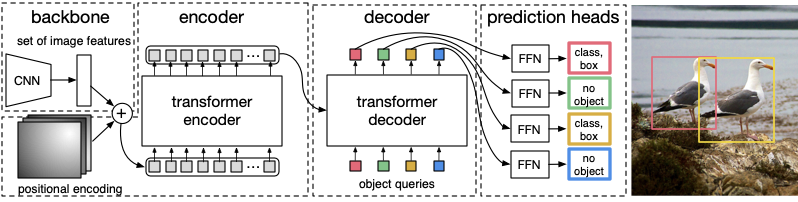

In [3]:
detr = DETRDemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url="https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth",
    map_location="cpu",
    check_hash=True,
)
detr.load_state_dict(state_dict)
detr.eval();

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /home/victor/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


  0%|          | 0.00/79.3M [00:00<?, ?B/s]

## Computing predictions with DETR


In [2]:
# COCO classes
CLASSES = [
    "N/A",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

# colors for visualization
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]

In [3]:
# standard PyTorch mean-std input image normalization
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(800),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


# for output bounding box post-processing
def box_cxcywh_to_xyxy(_x):
    x_c, y_c, _w, _h = _x.unbind(1)
    b = [(x_c - 0.5 * _w), (y_c - 0.5 * _h), (x_c + 0.5 * _w), (y_c + 0.5 * _h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def detect(input_img, _model, img_transform):
    # mean-std normalize the input image (batch-size: 1)
    _img = img_transform(input_img).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert (
        _img.shape[-2] <= 1600 and _img.shape[-1] <= 1600
    ), "demo model only supports images up to 1600 pixels on each side"

    # propagate through the model
    outputs = _model(_img)

    # keep only predictions with 0.7+ confidence
    probas = outputs["pred_logits"].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.2

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs["pred_boxes"][0, keep], input_img.size)
    return probas[keep], bboxes_scaled

## Using DETR

In [8]:
img = Image.open("input/img_00.jpg")

scores, boxes = detect(img, detr, transform)

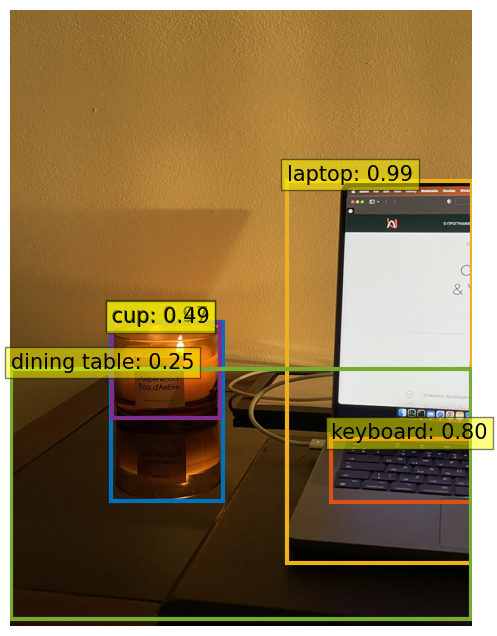

In [9]:
def plot_results(pil_img, vis_boxes, prob=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for i, ((x_min, y_min, x_max, y_max), c) in enumerate(
        zip(vis_boxes.tolist(), COLORS * 100)
    ):
        ax.add_patch(
            plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                fill=False,
                color=c,
                linewidth=3,
            )
        )
        if prob is not None:
            cl = prob[i].argmax()
            text = f"{CLASSES[cl]}: {prob[i][cl]:0.2f}"
            ax.text(
                x_min,
                y_min,
                text,
                fontsize=15,
                bbox=dict(facecolor="yellow", alpha=0.5),
            )
    plt.axis("off")
    plt.show()


plot_results(img, boxes, scores)

## Decoder/Encoder attention visualization

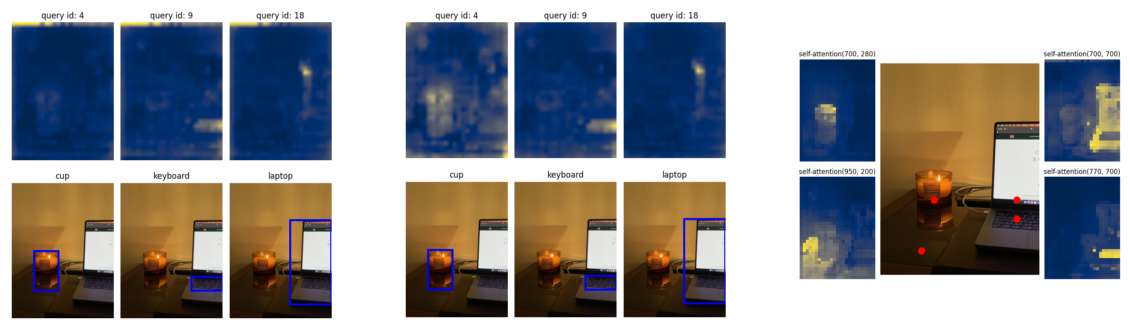

In [9]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 3)
ax[0].imshow(plt.imread("output/img_00_decoder.png"))
ax[1].imshow(plt.imread("img_00_decoder_crop.png"))
ax[2].imshow(plt.imread("img_00_encoder.png"))
for a in ax:
    a.axis("off")

# Fine-tuning DETR

## Dataset

In [11]:
!unzip input/balloon.zip

Archive:  input/balloon.zip
   creating: balloon/
   creating: balloon/train/
   creating: balloon/val/
  inflating: balloon/train/605521662_a470fef77f_b.jpg  
  inflating: balloon/train/9330497995_4cf0438cb6_k.jpg  
  inflating: balloon/train/5178670692_63a4365c9c_b.jpg  
  inflating: balloon/train/25899693952_7c8b8b9edc_k.jpg  
  inflating: balloon/train/14321263043_b76ef054d3_k.jpg  
  inflating: balloon/train/1297451346_5b92bdac08_b.jpg  
  inflating: balloon/train/126700562_8e27720147_b.jpg  
  inflating: balloon/train/2311771643_f46392fcc0_b.jpg  
  inflating: balloon/train/518678836_94d58e3839_b.jpg  
  inflating: balloon/train/5560377994_cb597a4af5_b.jpg  
  inflating: balloon/train/3927754171_9011487133_b.jpg  
  inflating: balloon/train/9210739293_2b0e0d991e_k.jpg  
  inflating: balloon/train/15717689633_5f7f78c28e_k.jpg  
  inflating: balloon/train/12288355124_5e340d3de3_k.jpg  
  inflating: balloon/train/2354829160_3f65a6bf6f_b.jpg  
  inflating: balloon/train/154446334_5d4

In [5]:
BATCH_SIZE = 4

In [10]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, detr_processor, train=True):
        ann_file = osp.join(
            img_folder, "custom_train.json" if train else "custom_val.json"
        )
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = detr_processor

    def __getitem__(self, idx):
        input_img, detr_target = super(CocoDetection, self).__getitem__(idx)
        _image_id = self.ids[idx]
        self.detr_target = {"image_id": _image_id, "annotations": detr_target}
        encoding = self.processor(
            images=input_img, annotations=self.detr_target, return_tensors="pt"
        )
        pixel_values = encoding["pixel_values"].squeeze()
        detr_target = encoding["labels"][0]

        return pixel_values, detr_target

In [11]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection("balloon/train", processor, train=True)
val_dataset = CocoDetection("balloon/val", processor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/victor/anaconda3/lib/python3.7/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  FutureWarning,


In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 61
Number of validation examples: 13


In [45]:
bb = train_dataset.detr_target["annotations"][0]["bbox"]

x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]

In [48]:
bb

[534, 365, 337, 446]

Image n°1


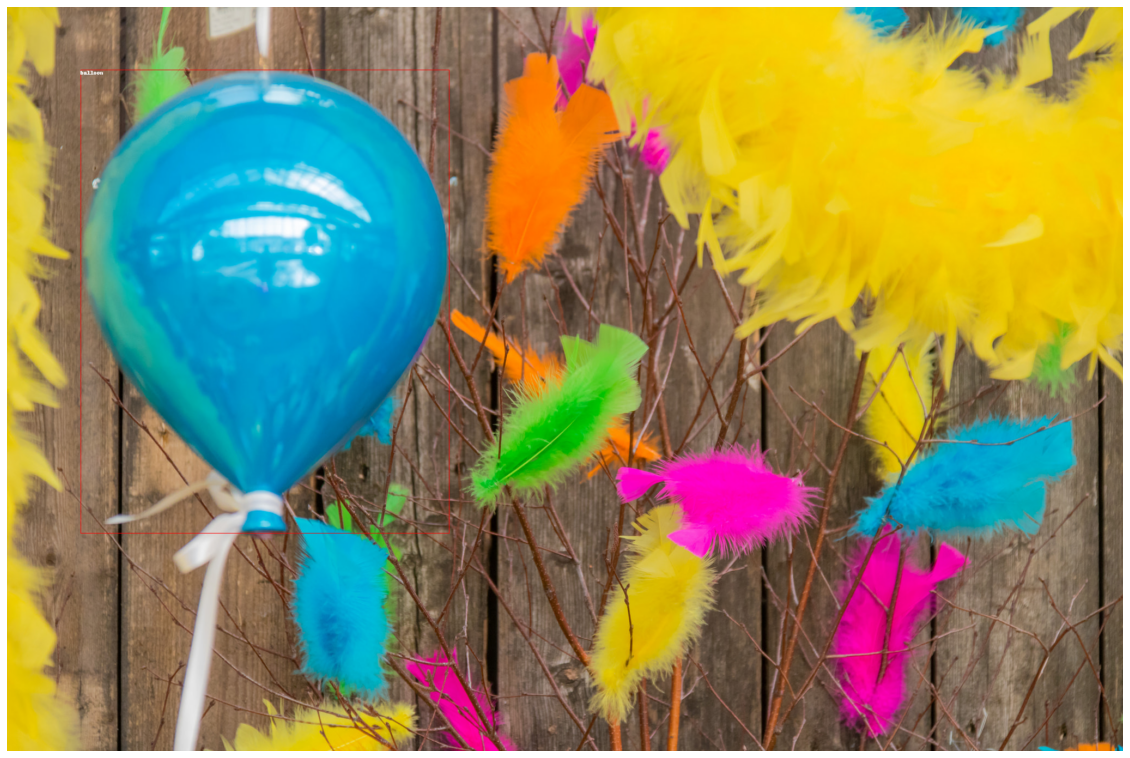

In [14]:
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print("Image n°{}".format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(osp.join("balloon/train", image["file_name"]))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v["name"] for k, v in cats.items()}

for annotation in annotations:
    box = annotation["bbox"]
    class_idx = annotation["category_id"]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

plt.imshow(image)
plt.axis("off")
plt.show()

In [10]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = dict()
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch


train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True
)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [11]:
for batch in tqdm(train_dataloader):
    pixel_values = batch["pixel_values"]
    pixel_mask = batch["pixel_mask"]
    labels = [{k: v for k, v in t.items()} for t in batch["labels"]]
    break

  0%|          | 0/16 [00:00<?, ?it/s]


In [15]:
labels[0]

{'size': tensor([ 800, 1066]),
 'image_id': tensor([31]),
 'class_labels': tensor([0, 0, 0]),
 'boxes': tensor([[0.5083, 0.1608, 0.1299, 0.3216],
         [0.4507, 0.1341, 0.2100, 0.2656],
         [0.3423, 0.3014, 0.2139, 0.3529]]),
 'area': tensor([2033.2335,  997.6400,  379.5369]),
 'iscrowd': tensor([0, 0, 0]),
 'orig_size': tensor([ 768, 1024])}

## Training

In [13]:
DEVICE = "cpu"
N_EPOCHS = 5
LR, LR_BACKBONE = 1e-4, 1e-5
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 0.1

In [14]:
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", num_labels=1, ignore_mismatched_sizes=True
).to(DEVICE)

Downloading:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/victor/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
param_dicts = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if "backbone" not in n and p.requires_grad
        ],
    },
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if "backbone" in n and p.requires_grad
        ],
        "lr": LR_BACKBONE,
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=LR, weight_decay=WEIGHT_DECAY)

In [19]:
def run_epoch(train=True):
    if train:
        dataloader = train_dataloader
        model.train()
    else:
        dataloader = val_dataloader
        model.eval()

    if train:
        optimizer.zero_grad()

    running_loss = 0.0

    for batch in tqdm(dataloader):
        pixel_values = batch["pixel_values"].to(DEVICE)
        pixel_mask = batch["pixel_mask"].to(DEVICE)
        labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        running_loss += outputs.loss.item()

        if train:
            outputs.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

    return running_loss / len(dataloader)

In [23]:
for epoch in range(N_EPOCHS):
    epoch_train_loss = run_epoch(train=True)
    with torch.no_grad():
        epoch_val_loss = run_epoch(train=False)
    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train loss: {epoch_train_loss:.4f} - Val loss: {epoch_val_loss:.4f}"
    )

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 1/5 - Train loss: 0.6999 - Val loss: 0.7810


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 2/5 - Train loss: 0.6561 - Val loss: 0.8846


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Epoch 3/5 - Train loss: 0.5901 - Val loss: 0.8773


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 4/5 - Train loss: 0.5844 - Val loss: 0.7724


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

Epoch 5/5 - Train loss: 0.4724 - Val loss: 0.6969


## Evaluation

In [21]:
def convert_to_xywh(_boxes):
    x_min, y_min, x_max, y_max = _boxes.unbind(1)
    return torch.stack((x_min, y_min, x_max - x_min, y_max - y_min), dim=1)


def prepare_for_coco_detection(_predictions):
    coco_results = []
    for original_id, prediction in _predictions.items():
        if len(prediction) == 0:
            continue

        _boxes = prediction["boxes"]
        _boxes = convert_to_xywh(_boxes).tolist()
        _scores = prediction["scores"].tolist()
        _labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": _labels[k],
                    "bbox": _box,
                    "score": _scores[k],
                }
                for k, _box in enumerate(_boxes)
            ]
        )
    return coco_results

In [24]:
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(val_dataloader):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(
        outputs, target_sizes=orig_target_sizes
    )

    predictions = {
        target["image_id"].item(): output for target, output in zip(labels, results)
    }
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ I

## Visualization

In [25]:
pixel_values, target = val_dataset[1]

pixel_values = pixel_values.unsqueeze(0).to(DEVICE)
model.to(DEVICE)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [26]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]


def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (x_min, y_min, x_max, y_max), c in zip(
        scores.tolist(), labels.tolist(), boxes.tolist(), colors
    ):
        ax.add_patch(
            plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                fill=False,
                color=c,
                linewidth=3,
            )
        )
        text = f"{score:0.2f}"
        ax.text(
            x_min, y_min, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5)
        )
    plt.axis("off")
    plt.show()

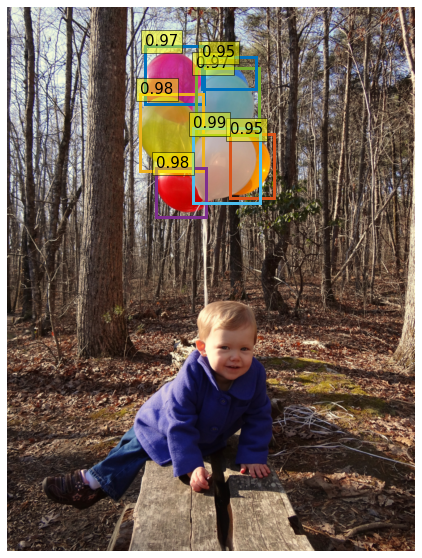

In [27]:
# load image based on ID
image_id = target["image_id"].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(osp.join("balloon/val", image["file_name"]))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.9
)

results = postprocessed_outputs[0]
plot_results(image, results["scores"], results["labels"], results["boxes"])

# Home task

В рамках домашнего задания вам необходимо:
* Дообучить DETR на задачу детекции лиц – 5 баллов
* Провизуализировать Decoder/Encoder attention для DETRDemo – 5 баллов

In [1]:
from torchvision import datasets, transforms
from datasets import load_dataset

import os.path as osp
from PIL import Image, ImageDraw
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont


from tqdm import tqdm

import numpy as np
import torch
import torchvision


from transformers import DetrImageProcessor, DetrForObjectDetection
from coco_eval import CocoEvaluator

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20.0, 16.0)
plt.rcParams["image.interpolation"] = "bilinear"
plt.rcParams["image.cmap"] = "gray"

2023-03-20 12:50:34.005993: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 12:50:34.006015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset = load_dataset("wider_face", split="validation")

Found cached dataset wider_face (/home/victor/.cache/huggingface/datasets/wider_face/default/1.0.0/b87ac8d8d65665ec6e3c2a5c6ec08d6fddb1b0f2d7f2dc3b5dcecdaf12adf22f)


In [3]:
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", num_labels=1, ignore_mismatched_sizes=True
)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/victor/anaconda3/lib/python3.7/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  FutureWarning,


In [ ]:
class Faces(object):
    def __init__(self, dataset, detr_processor):
        self.processor = detr_processor
        self.dataset = dataset

    def __getitem__(self, idx):
        input_img, detr_target = self.dataset.__getitem__(idx)
        _image_id = idx
        detr_target = {"image_id": _image_id, "annotations": detr_target}
        encoding = self.processor(images=input_img, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()

        bb = detr_target["bbox"]
        x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]

        detr_target = {
            "size": pixel_values.size()[1:],
            "image_id": torch.tensor(idx),
            "class_labels": torch.tensor(0).repeat(len()),
        }

        return pixel_values, detr_target


# {'size': tensor([ 800, 1066]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.5955, 0.5811, 0.2202, 0.3561]]), 'area': tensor([3681.5083]), 'iscrowd': tensor([0]), 'orig_size': tensor([1536, 2048])}

In [55]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(800),
        torchvision.transforms.ToTensor(),
    ]
)

In [105]:
img = dataset[1]["image"]
boxes = dataset[1]["faces"]["bbox"]

In [88]:
img1 = transform(img)

In [58]:
to_pil = transforms.ToPILImage()
img1 = to_pil(img)

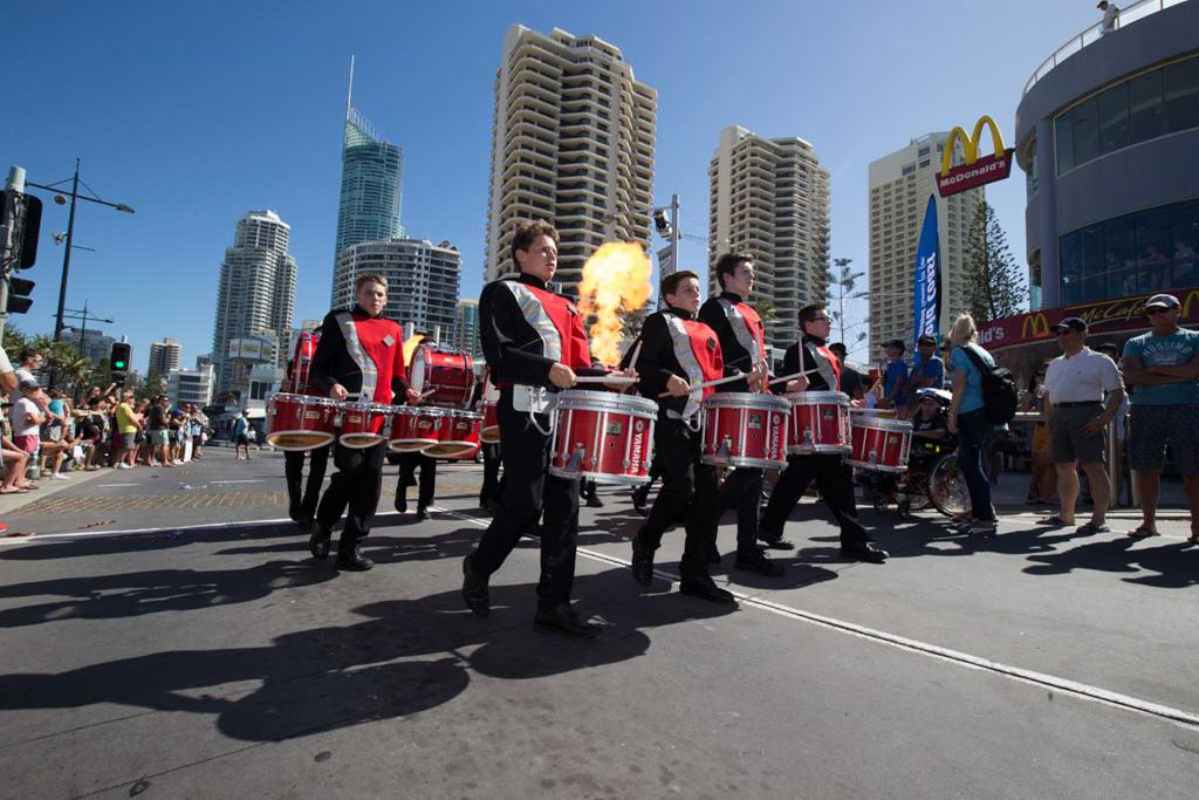

In [59]:
display(img1)

In [98]:
w = 1 / img1.size()[1]
h = 1 / img1.size()[2]

In [99]:
normed_boxes = torch.tensor(boxes) * torch.tensor([h, w, h, w]).unsqueeze(0)

In [100]:
normed_boxes[0] / torch.tensor([h, w, h, w])

tensor([ 26., 299.,  10.,  16.])

In [101]:
boxes[0]

[26.0, 299.0, 10.0, 16.0]

In [96]:
img2 = to_pil(img1)

In [102]:
def draw_boxes(original_image, det_boxes):
    annotated_image = original_image.copy()
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    for i in range(det_boxes.size(0)):
        # Boxes
        box_location = (det_boxes[i] / torch.tensor([h, w, h, w])).tolist()
        draw.rectangle(xy=box_location, outline="red")

    return annotated_image

In [106]:
draw_boxes(img1, normed_boxes)

AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = dict()
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

In [91]:
dataset[1]["faces"]["bbox"]

[[26.0, 299.0, 10.0, 16.0],
 [25.0, 329.0, 7.0, 11.0],
 [84.0, 341.0, 6.0, 8.0],
 [80.0, 329.0, 5.0, 6.0],
 [110.0, 335.0, 4.0, 9.0],
 [138.0, 337.0, 4.0, 8.0],
 [151.0, 351.0, 3.0, 5.0],
 [157.0, 342.0, 4.0, 8.0],
 [165.0, 346.0, 3.0, 6.0],
 [208.0, 349.0, 2.0, 4.0],
 [96.0, 338.0, 4.0, 7.0],
 [309.0, 238.0, 21.0, 30.0],
 [451.0, 197.0, 24.0, 42.0],
 [360.0, 290.0, 12.0, 18.0],
 [578.0, 234.0, 19.0, 31.0],
 [624.0, 219.0, 20.0, 33.0],
 [693.0, 263.0, 17.0, 26.0],
 [708.0, 296.0, 9.0, 15.0],
 [757.0, 293.0, 9.0, 11.0],
 [786.0, 290.0, 11.0, 13.0],
 [787.0, 340.0, 12.0, 13.0],
 [885.0, 315.0, 9.0, 13.0],
 [904.0, 278.0, 15.0, 20.0],
 [939.0, 296.0, 12.0, 14.0],
 [979.0, 261.0, 23.0, 17.0],
 [944.0, 214.0, 5.0, 7.0],
 [980.0, 209.0, 5.0, 7.0],
 [1005.0, 204.0, 5.0, 7.0],
 [733.0, 325.0, 7.0, 9.0]]

In [ ]:
dataset[0]

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, detr_processor, train=True):
        ann_file = osp.join(
            img_folder, "custom_train.json" if train else "custom_val.json"
        )
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = detr_processor

    def __getitem__(self, idx):
        input_img, detr_target = super(CocoDetection, self).__getitem__(idx)
        _image_id = self.ids[idx]
        detr_target = {"image_id": _image_id, "annotations": detr_target}
        encoding = self.processor(
            images=input_img, annotations=detr_target, return_tensors="pt"
        )
        pixel_values = encoding["pixel_values"].squeeze()
        detr_target = encoding["labels"][0]

        return pixel_values, detr_target

In [28]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [58]:
import deeplake

ds = deeplake.load("hub://activeloop/AFW")

hub://activeloop/AFW loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/AFW



In [79]:
ds[0].full_tensors

AttributeError: ignored

In [70]:
ds[0].__dict__

{'_client': None,
 'ds_name': 'AFW',
 'path': 'hub://activeloop/AFW',
 'storage': <deeplake.core.storage.lru_cache.LRUCache at 0x7f7a67b6a340>,
 '_read_only_error': False,
 '_read_only': True,
 'base_storage': <deeplake.core.storage.s3.S3Provider at 0x7f7afa380340>,
 '_locked_out': False,
 'is_iteration': False,
 'is_first_load': False,
 '_is_filtered_view': False,
 'index': Index(values=[<deeplake.core.index.index.IndexEntry object at 0x7f7a68a5c2e0>]),
 'group_index': '',
 '_token': None,
 'org_id': 'activeloop',
 'public': False,
 'verbose': False,
 'version_state': {'branch': 'main',
  'branch_commit_map': {'main': '2536dc6e63a440fe57cb598bb925d0b527f47c81'},
  'commit_node_map': {'firstdbf9474d461a19e9333c2fd19b46115348f': Commit : firstdbf9474d461a19e9333c2fd19b46115348f (main) 
   Author : istranic
   Time   : 2022-09-13 22:12:37
   Message: Uploaded the dataset,
   '2536dc6e63a440fe57cb598bb925d0b527f47c81': Commit : 2536dc6e63a440fe57cb598bb925d0b527f47c81 (main) 
   Author : 

In [63]:
dataloader = ds.pytorch(num_workers=1, batch_size=4, shuffle=False)

In [50]:
tform = transforms.Compose(
    [
        transforms.ToPILImage(),  # Must convert to PIL image for subsequent operations to run
        transforms.RandomRotation(20),  # Image augmentation
        transforms.ToTensor(),  # Must convert to pytorch tensor for subsequent operations to run
        transforms.Normalize([0.5], [0.5]),
        transforms.Resize([1000, 2000]),
    ]
)

In [65]:
train_loader = (
    ds.dataloader().transform({"images": tform, "l": None}).batch(4).shuffle().pytorch()
)

TensorDoesNotExistError: ignored

In [64]:
for batch in dataloader:
    break

RuntimeError: ignored